<a href="https://colab.research.google.com/github/kghilothia06/Time-Series-Forecasting/blob/main/01_LSTM_univariate_car_sales_14_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM examples for monthly and quarterly sales prediction

Import Libraries

In [22]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_excel
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from pandas import DataFrame

In [3]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]


In [5]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
  df = DataFrame(data)
  cols = list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  # put it all together
  agg = concat(cols, axis=1)
  # drop rows with NaN values
  agg.dropna(inplace=True)
  return agg.values


In [7]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))


In [8]:
# difference dataset
def difference(data, interval):
  return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [10]:
# fit a model
def model_fit(train, config):
  # unpack config
  n_input, n_nodes, n_epochs, n_batch, n_diff = config
  # prepare data
  if n_diff > 0:
    train = difference(train, n_diff)
  data = series_to_supervised(train, n_input)
  train_x, train_y = data[:, :-1], data[:, -1]
  train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
  # define model
  model = Sequential()
  model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model


In [11]:
# forecast with a pre-fit model
def model_predict(model, history, config):
  # unpack config
  n_input, _, _, _, n_diff = config
  # prepare data
  correction = 0.0
  if n_diff > 0:
    correction = history[-n_diff]
    history = difference(history, n_diff)
  x_input = array(history[-n_input:]).reshape((1, n_input, 1))
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return correction + yhat[0]

In [12]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # fit model
  model = model_fit(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  print(' > %.3f' % error)
  return error


In [13]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
  # fit and evaluate the model n times
  scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
  return scores


In [14]:
# summarize model performance
def summarize_scores(name, scores):
  # print a summary
  scores_m, score_std = mean(scores), std(scores)
  print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
  # box and whisker plot
  pyplot.boxplot(scores)
  pyplot.show()

Read quarterly and monthly datasets

 > 120930.584
 > 123132.511
 > 129775.933
 > 122864.124
 > 121340.622
 > 120239.943
 > 120280.177
 > 120335.667
 > 113134.972
 > 120239.951
 > 120605.832
 > 109093.311
 > 119642.656
 > 122592.733
 > 124020.161
 > 120823.363
 > 120239.941
 > 126454.176
 > 118742.647
 > 120239.942
 > 129164.312
 > 132085.258
 > 120239.943
 > 117580.293
 > 109815.259
 > 120246.804
 > 117547.396
 > 119113.977
 > 121352.235
 > 123163.973
lstm: 120834.623 RMSE (+/- 4787.240)


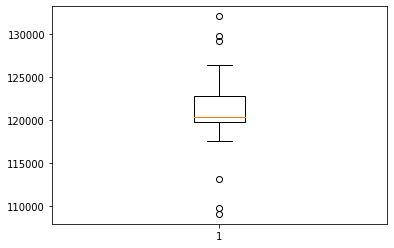

In [36]:
series = read_excel('/content/Sales-quarterly.xlsx', header=0, index_col=0)
series = DataFrame(series['Sales'])
data = series.values
# data split
n_test = 4
# define config = [n_input, n_nodes, n_epochs, n_batch, n_diff] 
# n_input: The number of lag observations to use as input to the model.
# n_nodes: The number of LSTM units to use in the hidden layer.
# n_epochs: The number of times to expose the model to the whole training dataset.
# n_batch: The number of samples within an epoch after which the weights are updated.
# n_diff: The difference order or 0 if not used
config = [1, 8, 10, 4, 4]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('lstm', scores)


 > 66527.812
 > 64821.393
 > 64827.851
 > 64678.635
 > 67687.131
 > 67131.523
 > 65219.028
 > 68343.792
 > 76656.592
 > 65418.675
 > 64658.638
 > 64598.726
 > 67148.244
 > 65318.586
 > 67893.311
 > 65033.284
 > 64053.588
 > 65837.049
 > 64631.017
 > 64795.039
 > 64368.948
 > 64315.032
 > 64646.524
 > 66144.106
 > 65597.437
 > 68572.852
 > 65420.196
 > 65335.526
 > 66483.950
 > 66440.944
lstm: 66086.848 RMSE (+/- 2318.320)


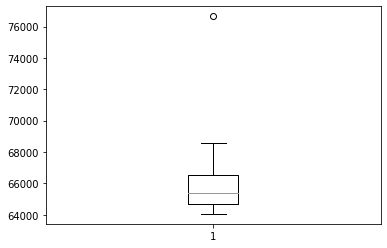

In [41]:
series = read_excel('/content/Sales-monthly.xlsx', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config = [n_input, n_nodes, n_epochs, n_batch, n_diff] 
# n_input: The number of lag observations to use as input to the model.
# n_nodes: The number of LSTM units to use in the hidden layer.
# n_epochs: The number of times to expose the model to the whole training dataset.
# n_batch: The number of samples within an epoch after which the weights are updated.
# n_diff: The difference order or 0 if not used
config = [5, 32, 10, 12, 12]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('lstm', scores)
